In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
import pickle

rectangular_ = 1
elliptic_ = 2

nCore_y = 2
nCore_z = 2
NTURN=[128,512]  # each period

In [2]:
emitGeomRMS = 3.3e-6
sigma_K = 2.0e-3
pipe = 0.025

In [3]:
NL_t = 0.4
NL_L = 1.8
NL_c = 0.01
NL_nu = 0.3
NL_beta = 0.5*NL_L/np.tan(np.pi*NL_nu)

# pipe_info start from NL center

In [4]:
pipe_info = np.loadtxt('../pipeinfo.in')
index_NLcenter = np.argmin(pipe_info[:,1])

L_tot = pipe_info[-1,0]
s_NLmid = pipe_info[index_NLcenter,0]
print(s_NLmid, L_tot)
print(pipe_info[index_NLcenter-2:index_NLcenter+3,:])

5.811519140000001 39.968229720000004
[[5.72580485e+00 4.03422000e-03 5.54705000e-03 2.00000000e+00]
 [5.76866200e+00 4.00858000e-03 5.51180000e-03 2.00000000e+00]
 [5.81151914e+00 4.00000000e-03 5.50000000e-03 2.00000000e+00]
 [5.85437628e+00 4.00858000e-03 5.51180000e-03 2.00000000e+00]
 [5.89723343e+00 4.03422000e-03 5.54705000e-03 2.00000000e+00]]


In [5]:
pipe_info[:,0] = pipe_info[:,0] - s_NLmid
pipe_info[:index_NLcenter,0] = pipe_info[:index_NLcenter,0] + L_tot
pipe_info = np.concatenate((pipe_info[index_NLcenter:,:],pipe_info[:index_NLcenter+1,:]),axis=0)

In [6]:
pipe_info[-1,0] = L_tot

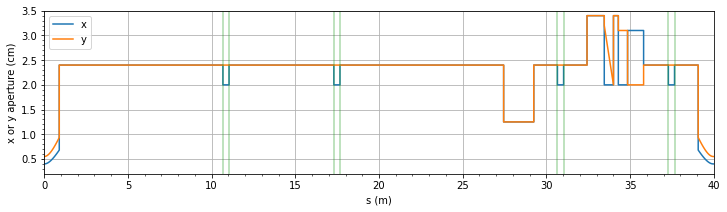

In [7]:
plt.figure(figsize=(12,3))
plt.plot(pipe_info[:,0],pipe_info[:,1]*100)
plt.plot(pipe_info[:,0],pipe_info[:,2]*100)
plt.plot(pipe_info[:,0],(pipe_info[:,3]-1)*10,alpha=0.4)
plt.grid()
plt.ylim((0.2,3.5))
plt.xlim((0.0, 40))
plt.minorticks_on()
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

In [8]:
np.savetxt('pipeinfo.in',pipe_info)

In [9]:
pipe_info[-4:,:]

array([[3.98396583e+01, 4.07659000e-03, 5.60531000e-03, 2.00000000e+00],
       [3.98825154e+01, 4.03422000e-03, 5.54705000e-03, 2.00000000e+00],
       [3.99253726e+01, 4.00858000e-03, 5.51180000e-03, 2.00000000e+00],
       [3.99682297e+01, 4.00000000e-03, 5.50000000e-03, 2.00000000e+00]])

# read Lattice

In [10]:
beam,lattice = impact.readInputFile('../test.Chad.in')
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)
emitN = emitGeomRMS*bg

reading ImpactZ input file (../test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [11]:
ap1_x,ap1_y = 4e-3, 5.5e-3
ang = np.arange(0.0,2*np.pi,2*np.pi/1024)
c = np.cos(ang)
s = np.sin(ang)

# prepare test particles

In [12]:
nx = 100
testP = 0.0
sig = 0.015
k=1
q_m = beam.multi_charge.q_m[0]
pTest = []
for x in np.linspace(-ap1_x,ap1_x,100):
    for y in np.linspace(-ap1_y,ap1_y,100):
        if (x/ap1_x)**2 + (y/ap1_y)**2 <= 1.0:
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])    
            k=k+1
            
pTest = np.array(pTest)
npt = len(pTest)
beam.n_particles = npt
npt

7668

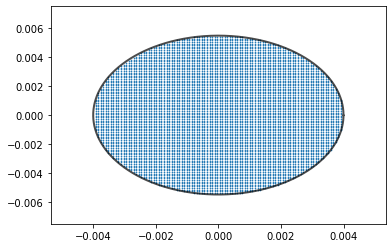

In [13]:
plt.scatter(pTest[:,0],pTest[:,2],s=0.4)
plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)

# ready to run

In [14]:
loop = impact.getElem('loop')
# loop.turns = nturn

writeIn = impact.getElem('write_raw_ptcl')
writeIn.turn = 1
writeIn.file_id = 100000
writeIn.format_id = 2

writetmp = impact.getElem('write_raw_ptcl')
# writetmp.turn = nturn
# writetmp.file_id = 100000 + nturn
writetmp.format_id = 2

writeOut = impact.getElem('write_raw_ptcl')
# writeOut.turn = nturn
# writeOut.file_id = 100000 - nturn
writeOut.format_id = 2

In [15]:
def getDA_data(deco,nturn,dp_CL,order=3):
    
    # read file   
    beam,lattice = impact.readInputFile('test_'+deco+'.in')
    beam.nCore_y = nCore_y
    beam.nCore_z = nCore_z
    beam.n_particles = npt
    ke = beam.kinetic_energy
    mass = beam.mass
    freq = beam.frequency
    
    # prepare particles
    pTest[:,5] = dp_CL*sigma_K*ke
    impact.writeParticleData(pTest, ke, mass, freq)
    beam.distribution.distribution_type = 'ReadFile'
    
    # prepare lattice
    writeOut.file_id = 100000 - nturn
    cleanLat = impact.clearLattice(lattice)
    for item in cleanLat:
        if item.type == 'RFkick':
            item.vmax = 0.0
        if 'length' in item:
            item.n_sckick = int(np.ceil(item.length*50))
            item.n_map = 1
        if 'pipe_radius' in item and item.type is not 'dipole':
            item.pipe_radius = pipe
            
    for iNL,elem in enumerate(cleanLat):
        if 'nonlinear' in elem.type:
            break
    
    NL0 = impact.getElem('nonlinear_insert_sliced')
    
    NL0.length = 0.9
    NL0.start_position = 0.0
    NL0.total_length = 1.8
    
    NL0.tune_advance = 0.3
    NL0.strength_t = 0.4
    NL0.transverse_scale_c = 0.01
    
    NL0.n_map = 45
    NL0.n_sckick = 1
    
    NL1 = copy(NL0)
    NL1.start_position = 0.9
    
    cleanLat =  [NL1] + cleanLat[iNL+1:] + cleanLat[:iNL] + [NL0]

    # add QFF
    cleanLat = impact.addHardEdgeQuad(cleanLat)
    
    
    # ==== run foward (from NL mid point) ====   
    loop.turns = nturn
    writetmp.turn = nturn
    writetmp.file_id = 100000 + nturn
    writeOut.turn = nturn
    lattice = [loop, impact.getElem('pipeinfo'), writeIn] + cleanLat + [writetmp]
      
    impact.writeInputFile(beam, lattice)
    impact.run(beam,order=order)
    


    # ==== run backward  ====
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = writetmp.file_id
    
    cleanLat_backward = impact.getInverseLattice(cleanLat)
    lattice = [loop] + cleanLat_backward + [writeOut]    
      
    impact.writeInputFile(beam, lattice)
    impact.run(beam,order=order)
    
    
    # collect data
    pDataIn  = impact.readParticleData(writeIn.file_id,  ke,mass,freq, writeIn.format_id)
    pDataOut = impact.readParticleData(writeOut.file_id, ke,mass,freq, writeOut.format_id)
    
    iSurvived = np.in1d(pDataIn[:,-1],pDataOut[:,-1])
    pDataIn = pDataIn[iSurvived,:]
    
    diff = np.log10(
              np.sqrt(
                       (pDataIn[:,0] - pDataOut[:,0])**2/(NL_beta*NL_c*NL_c) + 
                       (pDataIn[:,2] - pDataOut[:,2])**2/(NL_beta*NL_c*NL_c) +
                       (pDataIn[:,1] - pDataOut[:,1])**2*NL_beta/(NL_c*NL_c) + 
                       (pDataIn[:,3] - pDataOut[:,3])**2*NL_beta/(NL_c*NL_c) 
                     ) 
                   )
     
    return pDataIn[:,0], pDataIn[:,2], diff #, pDataIn, pDataOut

# Run and collect data

In [16]:
data = {}
# data = pickle.load(open('TBT_iota_v8_4_variousSextSettings_wAperture.pickle','rb'))
Deltas = ['delta=-2sigma','delta=0','delta=+2sigma']

In [17]:
deco = 'iota_v8_4_SextOff_NLon'
if deco not in data.keys():
    data[deco]={}
for nturn in NTURN:
    if nturn not in data[deco]:
        print(nturn)
        data[deco][nturn] = {}
        data[deco][nturn]['delta=-2sigma']=getDA_data(deco,nturn,-2)
        data[deco][nturn]['delta=0']      =getDA_data(deco,nturn, 0)
        data[deco][nturn]['delta=+2sigma']=getDA_data(deco,nturn, 2)
        pickle.dump(data,open('TBT_iota_v8_4_variousSextSettings_wAperture.pickle','wb'))    

128
reading ImpactZ input file (test_iota_v8_4_SextOff_NLon.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done
reading ImpactZ input file (test_iota_v8_4_SextOff_NLon.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param...

In [ ]:
deco = 'iota_v8_4_SextOn_NLon'
if deco not in data.keys():
    data[deco]={}
for nturn in NTURN:
    if nturn not in data[deco]:
        print(nturn)
        data[deco][nturn] = {}
        data[deco][nturn]['delta=-2sigma']=getDA_data(deco,nturn,-2)
        data[deco][nturn]['delta=0']      =getDA_data(deco,nturn, 0)
        data[deco][nturn]['delta=+2sigma']=getDA_data(deco,nturn, 2)
        pickle.dump(data,open('TBT_iota_v8_4_variousSextSettings_wAperture.pickle','wb'))    

128
reading ImpactZ input file (test_iota_v8_4_SextOn_NLon.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done
reading ImpactZ input file (test_iota_v8_4_SextOn_NLon.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param.....

# Data Anal

In [24]:
txt = [r'$\delta=-2\sigma_{\delta}$',r'$\delta=0$',r'$\delta=+2\sigma_{\delta}$']

### Off

In [25]:
deco = 'iota_v8_4_SextOff_NLon'

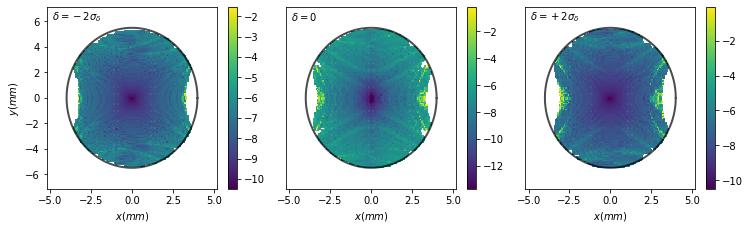

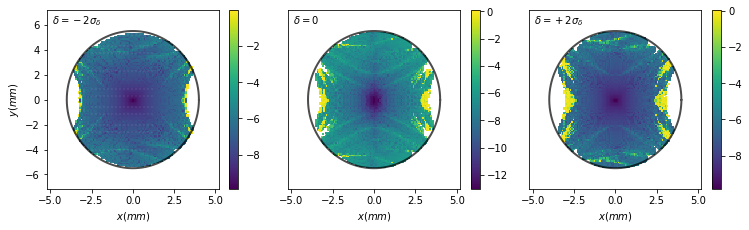

In [26]:
for nturn in NTURN:
    fig = plt.figure(figsize=[4+3.3+3.3,3.3])
    for j in range(3):
        x = data[deco][nturn][Deltas[j]][0]
        y = data[deco][nturn][Deltas[j]][1]
        d = data[deco][nturn][Deltas[j]][2]
    #     pDataIn = data[deco][Deltas[1]][3]
    #     pDataIn = data[deco][Deltas[1]][4]
        plt.subplot(1,3,j+1)
        f1=plt.scatter(x*1e3,y*1e3,c=d,s=1.6,marker='s')
        plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
        plt.xlim(-ap1_x*1.3*1e3,ap1_x*1.3*1e3)
        plt.ylim(-ap1_y*1.3*1e3,ap1_y*1.3*1e3)
        plt.xlabel('$x (mm)$')
        if j==0:
            plt.ylabel('$y (mm)$')
        else:
            plt.yticks([])
        plt.text(-4.9,6.1,txt[j])
        plt.colorbar(f1)
    plt.tight_layout()
    plt.savefig('DA_'+deco+'_wAperture_T'+str(nturn)+'.png',dpi=180)

### On

In [27]:
deco = 'iota_v8_4_SextOn_NLon'

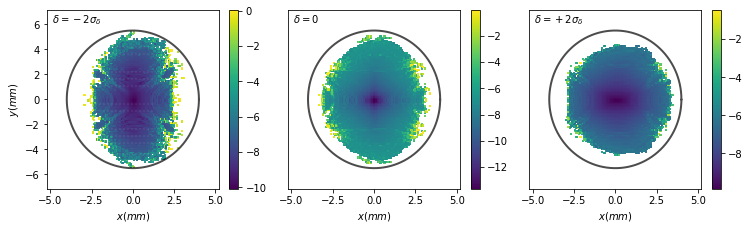

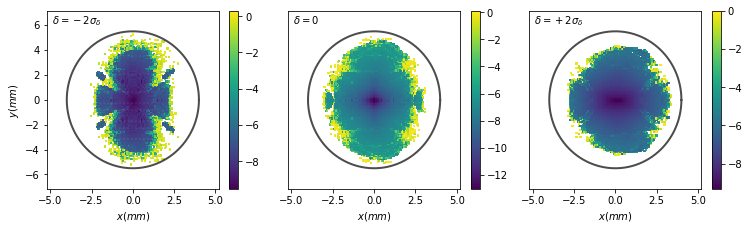

In [28]:
for nturn in NTURN:
    fig = plt.figure(figsize=[4+3.3+3.3,3.3])
    for j in range(3):
        x = data[deco][nturn][Deltas[j]][0]
        y = data[deco][nturn][Deltas[j]][1]
        d = data[deco][nturn][Deltas[j]][2]
    #     pDataIn = data[deco][Deltas[1]][3]
    #     pDataIn = data[deco][Deltas[1]][4]
        plt.subplot(1,3,j+1)
        f1=plt.scatter(x*1e3,y*1e3,c=d,s=1.6,marker='s')
        plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
        plt.xlim(-ap1_x*1.3*1e3,ap1_x*1.3*1e3)
        plt.ylim(-ap1_y*1.3*1e3,ap1_y*1.3*1e3)
        plt.xlabel('$x (mm)$')
        if j==0:
            plt.ylabel('$y (mm)$')
        else:
            plt.yticks([])
        plt.text(-4.9,6.1,txt[j])
        plt.colorbar(f1)
    plt.tight_layout()
    plt.savefig('DA_'+deco+'_wAperture_T'+str(nturn)+'.png',dpi=180)